In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay, auc)
import pickle
from numpy.lib.stride_tricks import sliding_window_view
from scipy import interpolate

%load_ext autoreload
%autoreload 2

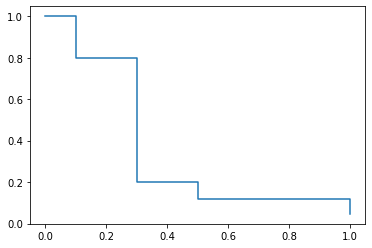

In [2]:
recalls = np.array([1,1,0.5, 0.3,0.1,0])
precisions = np.array([0.04640719, 0.11654135, 0.2, 0.8, 1.0, 1.0])

fig, ax = plt.subplots()
ax.plot(recalls, precisions, drawstyle='steps-post')

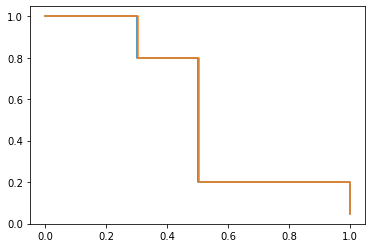

In [3]:
x = recalls[::-1]
y = precisions[::-1]
f = interpolate.interp1d(x, y, kind='zero')

xnew = np.linspace(0, 1, 100)
ynew = f(xnew)

fig, ax = plt.subplots()

ax.plot(x, y, drawstyle='steps-post')
ax.plot(xnew, ynew, drawstyle='steps-post')

In [24]:
def interpolate_curves(x, y, x_axis_n=1000, mode=None):
    if mode=='pr':
        x = x[::-1]
        y = y[::-1]
    
    f = interpolate.interp1d(x, y, kind='zero')

    xnew = np.linspace(0, 1, x_axis_n)
    ynew = f(xnew)

    return xnew, ynew

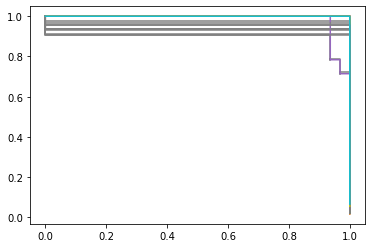

In [27]:
p = "12545393_knn_2022-08-23-1431-29_cnc_model_metrics_dict.pkl"
# p= "18600077_rf_2022-08-22-0739-49_cnc_model_metrics_dict.pkl"

with open(Path(p), "rb") as f:
    m = pickle.load(f)

precisions_interp = []
recalls_interp = []

fig, ax = plt.subplots()
for r, p in zip(m["recalls_array"], m["precisions_array"]):
    ax.plot(r, p, drawstyle='steps-post', color='grey')

    r_interp, p_interp = interpolate_curves(r, p, x_axis_n=1000, mode='pr')

    precisions_interp.append(p_interp)
    recalls_interp.append(r_interp)

    ax.plot(r_interp, p_interp, drawstyle='steps-post',)

    # ax.plot(r_interp, p_interp, drawstyle='steps-post')

    

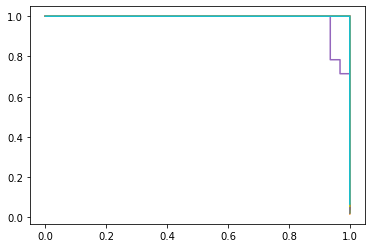

In [23]:
fig, ax = plt.subplots()

for r_interp, p_interp in zip(recalls_interp, precisions_interp):
    ax.plot(r_interp, p_interp, drawstyle='steps-post')


In [21]:
len(precisions_interp)

10

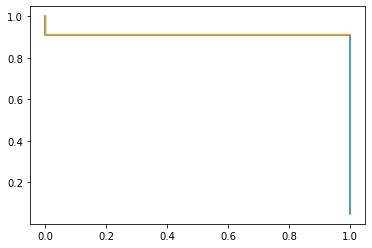

In [35]:
# load model_metrics_dict from pickle
p = "12545393_knn_2022-08-23-1431-29_cnc_model_metrics_dict.pkl"
# p= "18600077_rf_2022-08-22-0739-49_cnc_model_metrics_dict.pkl"


with open(Path(p), "rb") as f:
    m = pickle.load(f)

i = 0
precisions = m['precisions_array'][i]
recalls = m['recalls_array'][i]

fig, ax = plt.subplots()
x = recalls
y = precisions
ax.plot(x, y, drawstyle='steps-post')

x = recalls[::-1]
y = precisions[::-1]

# x = recalls
# y = precisions
f = interpolate.interp1d(x, y, kind='next')

xnew = np.linspace(0, 1, 1000)
ynew = f(xnew)

ax.plot(xnew, ynew, drawstyle='steps-post', color='orange')

In [36]:
def interpolate_curves(x, y, x_axis_n=1000, mode=None):
    if mode=='pr':
        x = x[::-1]
        y = y[::-1]
    
    f = interpolate.interp1d(x, y, kind='next')

    xnew = np.linspace(0, 1, x_axis_n)
    ynew = f(xnew)

    return xnew, ynew

In [37]:
def plot_pr_roc_curves_kfolds(
    precision_array,
    recall_array,
    fpr_array,
    tpr_array,
    rocauc_array,
    prauc_array,
    percent_anomalies_truth=0.073,
    path_save_dir=None,
    save_name="model_curves",
    save_plot=False,
    dpi=300,
):
    """
    Plot the precision-recall curves and the ROC curves for the different k-folds used in
    cross-validation. Also show the average PR and ROC curves.

    :param precision_array: array of precision values for each k-fold
    :param recall_array: array of recall values for each k-fold
    :param fpr_array: array of false positive rate values for each k-fold
    :param tpr_array: array of true positive rate values for each k-fold
    :param rocauc_array: array of ROC AUC values for each k-fold
    :param prauc_array: array of PR AUC values for each k-fold
    :param percent_anomalies_truth: the percentage of anomalies in the dataset

    """

    # sns whitegrid context
    sns.set(style="whitegrid", context="notebook")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
    fig.tight_layout(pad=5.0)

    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

    ######
    # plot the precision recall curves
    precisions_all_segmented = []
    for p, r in zip(precision_array, recall_array):
        r_adj, p_adj = interpolate_curves(r, p, x_axis_n=10000, mode='pr')
        precisions_all_segmented.append(p_adj)

    precisions_all_segmented = np.array(precisions_all_segmented)

    for i, (p, r) in enumerate(zip(precision_array, recall_array)):
        if i == np.shape(precision_array)[0] - 1:
            axes[0].plot(
                r[:], p[:], label="k-fold model", color="grey", alpha=0.5, linewidth=1, drawstyle='steps-post'
            )
        else:
            axes[0].plot(r[:], p[:], color="grey", alpha=0.5, linewidth=1, drawstyle='steps-post')

    axes[0].plot(
        r_adj,
        precisions_all_segmented.mean(axis=0),
        label="Average model",
        color=pal[5],
        linewidth=2,
        drawstyle='steps-post',
    )

    axes[0].plot(
        np.array([0, 1]),
        np.array([percent_anomalies_truth, percent_anomalies_truth]),
        marker="",
        linestyle="--",
        label="No skill model",
        color="orange",
        linewidth=2,
        zorder=0,
    )

    axes[0].legend()
    axes[0].title.set_text("Precision-Recall Curve")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].text(
        x=-0.05,
        y=-0.3,
        s=f"PR AUC: {prauc_array.mean():.3f} (avg), {prauc_array.min():.3f} (min), {prauc_array.max():.3f} (max)",
        # fontsize=10,
        horizontalalignment="left",
        verticalalignment="center",
        rotation="horizontal",
        alpha=1,
    )

    ######
    # plot the ROC curves
    roc_all_segmented = []
    for t, f in zip(tpr_array, fpr_array):
        f_adj, t_adj = interpolate_curves(f, t, x_axis_n=10000)
        roc_all_segmented.append(t_adj)

    roc_all_segmented = np.array(roc_all_segmented)

    for i, (t, f) in enumerate(zip(tpr_array, fpr_array)):
        if i == np.shape(tpr_array)[0] - 1:
            axes[1].plot(
                f[:], t[:], label="k-fold models", color="grey", alpha=0.5, linewidth=1, drawstyle='steps-post'
            )
        else:
            axes[1].plot(f[:], t[:], color="grey", alpha=0.5, linewidth=1, drawstyle='steps-post')

    axes[1].plot(
        f_adj,
        roc_all_segmented.mean(axis=0),
        label="Average of k-folds",
        color=pal[5],
        linewidth=2,
        drawstyle='steps-post',
    )

    axes[1].plot(
        np.array([0, 1]),
        np.array([0, 1]),
        marker="",
        linestyle="--",
        label="No skill",
        color="orange",
        linewidth=2,
        zorder=0,
    )

    axes[1].title.set_text("ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].text(
        x=-0.05,
        y=-0.3,
        s=f"ROC AUC: {rocauc_array.mean():.3f} (avg), {rocauc_array.min():.3f} (min), {rocauc_array.max():.3f} (max)",
        # fontsize=10,
        horizontalalignment="left",
        verticalalignment="center",
        rotation="horizontal",
        alpha=1,
    )

    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True, which="major")
        ax.grid(False)

    if save_plot:
        if path_save_dir is None:
            path_save_dir = "./"

        # save as both png and pdf
        plt.savefig(path_save_dir / f"{save_name}.png", dpi=dpi, bbox_inches="tight")
        plt.savefig(path_save_dir / f"{save_name}.pdf", bbox_inches="tight")
        plt.cla()
        plt.close()
    else:
        plt.show()

    return r_adj, precisions_all_segmented

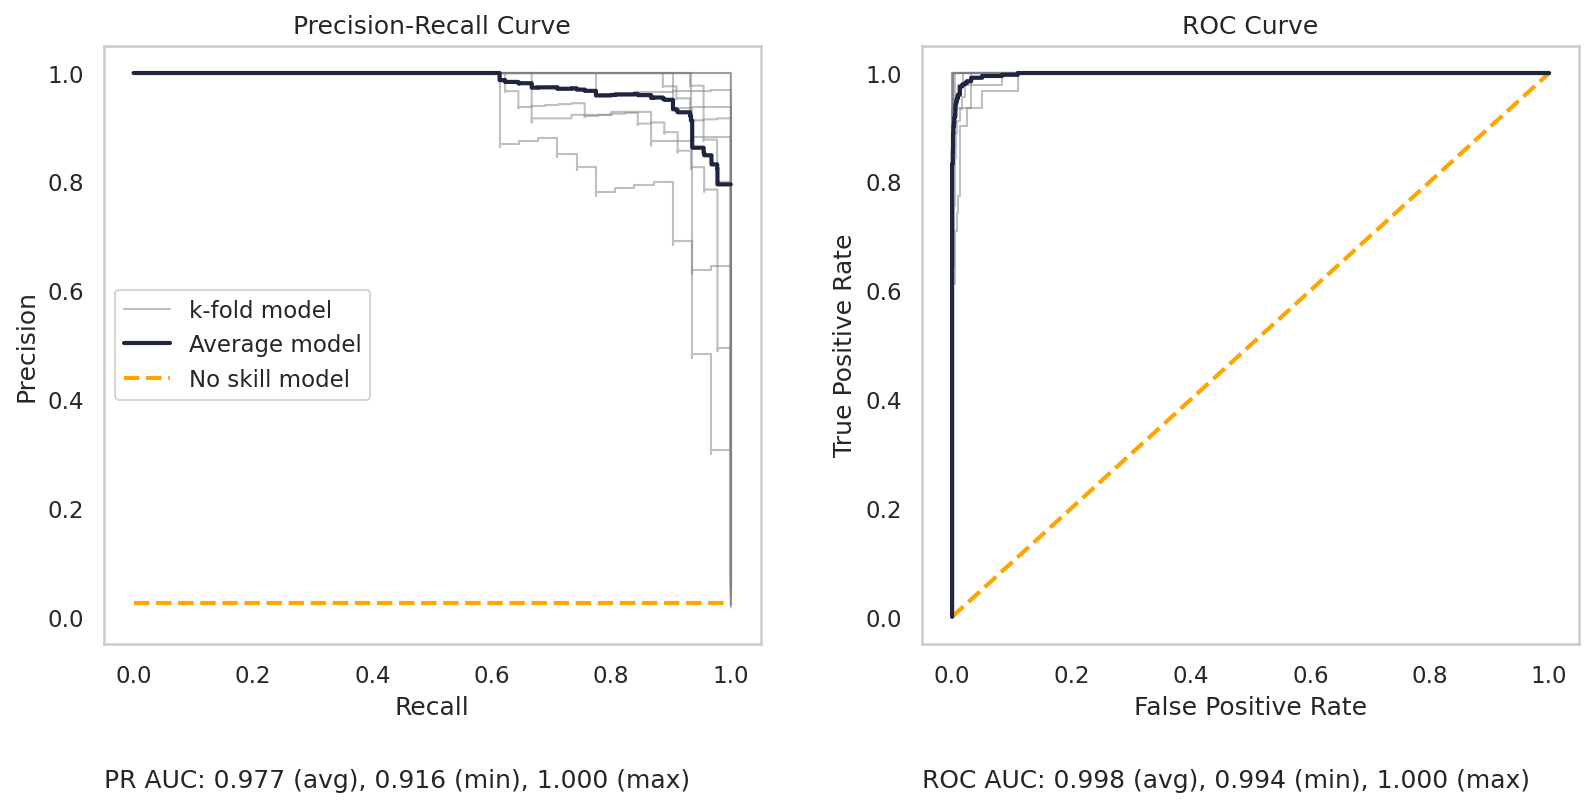

In [41]:
p= "18600077_rf_2022-08-22-0739-49_cnc_model_metrics_dict.pkl"
# p = "12545393_knn_2022-08-23-1431-29_cnc_model_metrics_dict.pkl"
with open(Path(p), "rb") as f:
    model_metrics_dict = pickle.load(f)

r_adj, precisions_all_segmented = plot_pr_roc_curves_kfolds(
                model_metrics_dict["precisions_array"],
                model_metrics_dict["recalls_array"],
                model_metrics_dict["fpr_array"],
                model_metrics_dict["tpr_array"],
                model_metrics_dict["rocauc_array"],
                model_metrics_dict["prauc_array"],
                percent_anomalies_truth=0.026,
                save_name=f"curve_{id}",
                save_plot=False,
                dpi=300,
            )

In [264]:
precisions_all_segmented[8]

array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
       0.05506217])

In [258]:
r_adj

array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
       9.99799980e-01, 9.99899990e-01, 1.00000000e+00])

In [185]:
x = recalls
y = precisions
x_axis_n = 7
for i in sliding_window_view(np.linspace(0, 1, x_axis_n), 2):
    window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]
    print(i, window_segment)

[0.         0.16666667] [4 5]
[0.16666667 0.33333333] [3]
[0.33333333 0.5       ] [2]
[0.5        0.66666667] [2]
[0.66666667 0.83333333] []
[0.83333333 1.        ] [0 1]


In [168]:
x = recalls
y = precisions
x_axis_n = 10


x_adj = list(x[:2])  # y values, adjusted
y_adj = list(y[:2])  # x values, adjusted

# y_adj = []  # y values, adjusted
# x_adj = []  # x values, adjusted

for i in sliding_window_view(np.linspace(0, 1, x_axis_n+1), 2)[::-1]:
    window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]
    # print(window_segment)


    # if there are no values in the window, then
    # use the last precision value in the window
    if len(window_segment) == 0:
        x_adj.append(np.mean(i))
        y_adj.append(y_adj[-1])
    else:
        x_adj.append(np.mean(i))
        y_adj.append(np.max(y[window_segment]))

x_adj.extend(list(x[-2:]))
y_adj.extend(list(y[-2:]))

In [169]:
print(x_adj)
print(y_adj)

[1.0, 1.0, 0.95, 0.8500000000000001, 0.75, 0.6500000000000001, 0.55, 0.45, 0.35000000000000003, 0.25, 0.15000000000000002, 0.05, 0.1, 0.0]
[0.04640719, 0.11654135, 0.11654135, 0.11654135, 0.11654135, 0.11654135, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0]


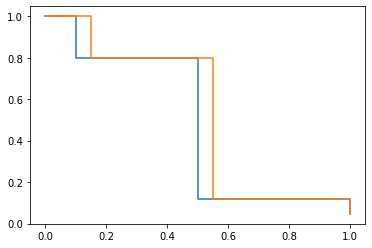

In [170]:
fig, ax = plt.subplots()

ax.plot(recalls, precisions, drawstyle='steps-post')
ax.plot(x_adj, y_adj, drawstyle='steps-post')

In [174]:
def segment_line_by_sliding_window(x, y, x_axis_n=1000):

    # x_adj = list(x[:2])  # y values, adjusted
    # y_adj = list(y[:2])  # x values, adjusted

    x_adj = []  # x values, adjusted
    y_adj = []  # y values, adjusted


    for i in sliding_window_view(np.linspace(0, 1, x_axis_n+1), 2)[::-1]:
        window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]
        # print(window_segment)


        # if there are no values in the window, then
        # use the last precision value in the window
        if len(window_segment) == 0:
            x_adj.append(np.mean(i))
            y_adj.append(y_adj[-1])
        else:
            x_adj.append(np.mean(i))
            y_adj.append(np.max(y[window_segment]))

    # x_adj.extend(list(x[-2:]))
    # y_adj.extend(list(y[-2:]))

    return np.array(x_adj), np.array(y_adj)

In [175]:
# load model_metrics_dict from pickle "12545393_knn_2022-08-23-1431-29_cnc_model_metrics_dict.pkl"
with open(Path("./12545393_knn_2022-08-23-1431-29_cnc_model_metrics_dict.pkl"), "rb") as f:
    m = pickle.load(f)

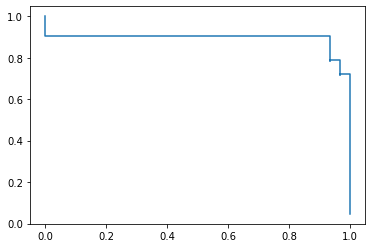

In [176]:
i = 4
precisions = m['precisions_array'][i]
recalls = m['recalls_array'][i]

fig, ax = plt.subplots()
ax.plot(recalls, precisions, drawstyle='steps-post')

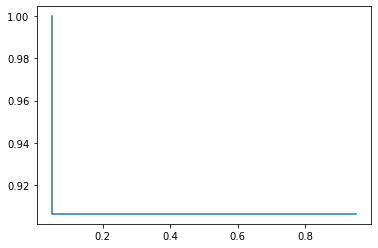

In [163]:
r_adj, p_adj = segment_line_by_sliding_window(recalls, precisions, x_axis_n=10)
fig, ax = plt.subplots()
ax.plot(r_adj, p_adj, drawstyle='steps-post')

In [10]:
m.keys()

dict_keys(['precisions_array', 'recalls_array', 'precision_score_array', 'recall_score_array', 'fpr_array', 'tpr_array', 'prauc_array', 'rocauc_array', 'f1_score_array', 'mcc_array', 'n_thresholds_array', 'accuracy_array', 'unique_grouping', 'confusion_matrix', 'df_feat_imp'])

0.9401568292715833


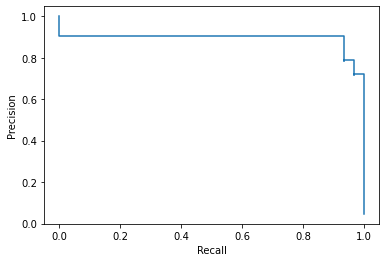

In [31]:
precisions = m['precisions_array'][4]
recalls = m['recalls_array'][4]

print(auc(recalls, precisions))

disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
disp.plot()
plt.show()

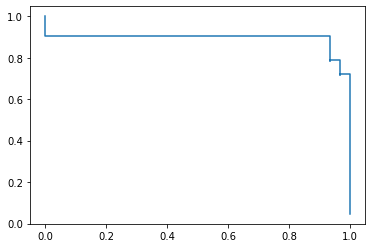

In [48]:
line_kwargs = {"drawstyle": "steps-post"}

fig, ax = plt.subplots()
ax.plot(recalls, precisions, drawstyle='steps-post')

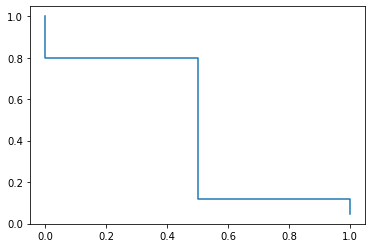

In [128]:
fig, ax = plt.subplots()
ax.plot(recalls, precisions, drawstyle='steps-post')

In [124]:
window_segment

array([0, 1])

In [118]:
def segment_line_by_sliding_window(x, y, x_axis_n=1000):

    y_adj = []  # y values, adjusted
    x_adj = []  # x values, adjusted

    x = x[::-1]
    y = y[::-1]
    # break the x-axis up by moving a sliding window along it
    for j, i in enumerate(sliding_window_view(np.linspace(0, 1, x_axis_n), 2)):
        window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]

        # if there are no values in the window, then
        # use the last precision value in the window
        if len(window_segment) == 0:
            x_adj.append(np.mean(i))
            y_adj.append(y_adj[-1])
        else:
            x_adj.append(np.mean(i))
            y_adj.append(np.min(y[window_segment]))

    return np.array(x_adj), np.array(y_adj)

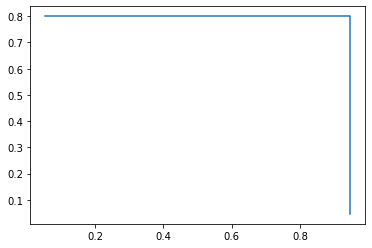

In [119]:
r_adj, p_adj = segment_line_by_sliding_window(recalls, precisions, x_axis_n=10)
fig, ax = plt.subplots()
ax.plot(r_adj, p_adj, drawstyle='steps-post')

In [122]:
x = recalls

x_axis_n = 10

for j, i in enumerate(sliding_window_view(np.linspace(0, 1, x_axis_n), 2)):
    window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]
    print(window_segment)

[3 4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [80]:
sliding_window_view(np.linspace(0, 1, x_axis_n), 2)

array([[0.      , 0.001001],
       [0.001001, 0.002002],
       [0.002002, 0.003003],
       ...,
       [0.996997, 0.997998],
       [0.997998, 0.998999],
       [0.998999, 1.      ]])

In [87]:
window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]

In [88]:
window_segment

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

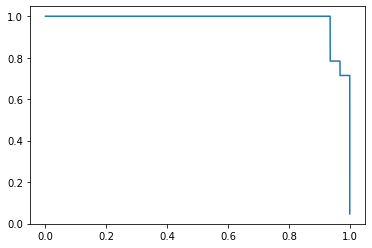